In [5]:
!pip install -q tensorflow tensorflow-datasets

In [7]:
!pip install -q tensorflow-datasets
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# List available datasets
print(tfds.list_builders())

# Load the dataset. 'oxford_iiit_pet' is used here as an example.
# Replace it with a valid dataset name from the list.
dataset, metadata = tfds.load('oxford_iiit_pet', with_info=True)

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'ai2dcaption', 'aloha_mobile', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asimov_dilemmas_auto_val', 'asimov_dilemmas_scifi_train', 'asimov_dilemmas_scifi_val', 'asimov_injury_val', 'asimov_multimodal_auto_val', 'asimov_multimodal_manual_val', 'asqa', 'asset', 'assin2', 'asu_table_top_converted_externally_to_rlds', 'austin_buds_dataset_converted_externally_to_rlds', 'austin_sailor_dataset_converted_externally_to_rlds', 'austin_sirius_dataset_converted_externally_to_rlds', 'bair_robot_pushing_small', 'bc_z', 'bccd', 'beans', 'bee_dataset', 'beir', 'berkeley_autolab_ur5', 'berkeley_cable_routing', 'berkeley_fanuc_manipulation', 'berkeley_gnm_cory_hall', 'berkeley_gnm_recon', 'berkeley_gnm_sac_son', 'berkeley_mvp_converted_externally_to_rlds', 'berkeley_rpt_converted_externally_to_rlds', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'b

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XATSVE_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XATSVE_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [9]:
def show(example):
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.title('Input Image (Label Map)')
  plt.imshow(tf.keras.utils.array_to_img(example['image']))
  plt.subplot(1, 2, 2)
  plt.title('Target Image (Facade)')
  plt.imshow(tf.keras.utils.array_to_img(example['label']))
  plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


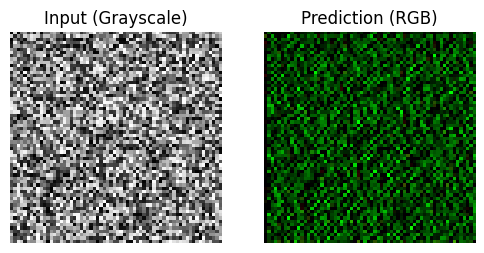

Simple image-to-image 'translation' done!
This is a very basic example and doesn't involve training.


In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1. Create some very simple dummy data
def create_dummy_data(num_examples=5):
  input_images = np.random.rand(num_examples, 64, 64, 1).astype(np.float32) # Grayscale input
  target_images = np.random.rand(num_examples, 64, 64, 3).astype(np.float32) # RGB output
  return tf.data.Dataset.from_tensor_slices((input_images, target_images)).batch(1)

train_dataset = create_dummy_data()

# 2. Build a very simple "translator" model
def simple_generator():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1))
  ])
  return model

generator = simple_generator()

# 3. See the "translation" (which will be random at this stage)
def show_prediction(input_image, predicted_image):
  plt.figure(figsize=(6, 3))
  plt.subplot(1, 2, 1)
  plt.title('Input (Grayscale)')
  plt.imshow(input_image[0, ..., 0], cmap='gray')
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.title('Prediction (RGB)')
  plt.imshow(predicted_image[0])
  plt.axis('off')
  plt.show()

for input_example, target_example in train_dataset.take(1):
  prediction = generator(input_example)
  show_prediction(input_example, prediction)

print("Simple image-to-image 'translation' done!")
print("This is a very basic example and doesn't involve training.")

In [20]:
def simple_discriminator():
    input_image = tf.keras.layers.Input(shape=(64, 64, 1))
    target_image = tf.keras.layers.Input(shape=(64, 64, 3))

    x = tf.keras.layers.Concatenate()([input_image, target_image])
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(1, (3, 3), strides=2, padding='same')(x)

    return tf.keras.Model(inputs=[input_image, target_image], outputs=x)

discriminator = simple_discriminator()

In [21]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + 100 * l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + fake_loss

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

In [24]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")
    for input_image, target in train_dataset:
        train_step(input_image, target)
    print("Done!")

Epoch 1
Done!
Epoch 2
Done!
Epoch 3
Done!


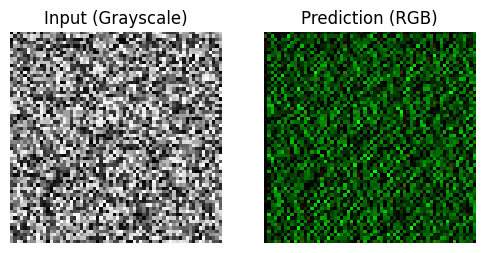

In [26]:
for input_example, target_example in train_dataset.take(1):
    prediction = generator(input_example, training=False)
    show_prediction(input_example, prediction)